# Selection of Optimal Number of Neighbors for Manifold Learning

This notebook implements a systematic approach to select the optimal number of neighbors 
for LLE and ISOMAP algorithms using geodesic stress and neighbor preservation metrics.

Key Components:
1. Implementation of evaluation metrics:
   - Geodesic stress computation
   - Neighbor preservation accuracy
   
2. Parameter optimization:
   - Tests neighbor values from 5 to 90
   - Combines metrics with 50-50 weighting
   - Generates visualization of error curves
   
3. Results storage:
   - Best parameters for each dataset
   - Error curves and 2D embeddings
   
The optimal parameters found are used in subsequent experimental comparisons.

In [1]:
import config
from data_utils import DatasetManager, load_datasets


c:\Users\levovo pro p50\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Synthetic datasets

## Load datasets

In [2]:
dataset_name = 'data_synthetic.pkl'
save_path = config.DATA_DIR

manager = DatasetManager(dataset_name, save_path, load_datasets)
datasets = manager.load_dataset()
dataset = datasets['Helicoids']
print(dataset[0].shape)

data_synthetic.pkl not found locally. Loading using load_datasets...
Loaded and saved to data/data_synthetic.pkl.
(1000, 3)


## neighbor_preservation_accuracy


In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def neighbor_preservation_score(X_high, X_low, n_neighbors=5):
    n_samples = X_high.shape[0]
    if X_low.shape[0] != n_samples:
        raise ValueError("X_high and X_low must have the same number of samples.")
    if n_neighbors >= n_samples:
        raise ValueError("n_neighbors must be < n_samples.")

    # 1) Neighbors in the original space
    nbrs_high = NearestNeighbors(n_neighbors=n_neighbors).fit(X_high)
    neighbors_high = nbrs_high.kneighbors(return_distance=False)

    # 2) Neighbors in the embedded space
    nbrs_low = NearestNeighbors(n_neighbors=n_neighbors).fit(X_low)
    neighbors_low = nbrs_low.kneighbors(return_distance=False)

    total_score = 0.0
    for i in range(n_samples):
        # Both sets now have exactly n_neighbors elements
        set_high = set(neighbors_high[i])
        set_low = set(neighbors_low[i])

        # Intersection size
        intersect_size = len(set_high.intersection(set_low))

        # fraction of neighbors preserved for point i
        score_i = intersect_size / float(n_neighbors)
        total_score += score_i

    # Average over all points
    return total_score / n_samples

## Compute reconstruction errors and neighbors accuracy for LLE and ISOMAP

In [5]:
import numpy as np
from scipy.sparse.csgraph import shortest_path
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import LocallyLinearEmbedding, Isomap
def compute_geodesic_distances(X, n_neighbors=5):
    """
    Compute geodesic distances between all pairs of points using shortest path through k-NN graph.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data
    n_neighbors : int, default=5
        Number of neighbors to use for k-NN graph construction
        
    Returns
    -------
    geodesic_dist : ndarray of shape (n_samples, n_samples)
        Matrix of pairwise geodesic distances
    """
    # Construct k-NN graph
    connectivity = kneighbors_graph(
        X, n_neighbors=n_neighbors, mode='distance', include_self=True
    )
    
    # Compute shortest path through the graph
    geodesic_dist = shortest_path(
        connectivity, directed=False, method='auto'
    )
    
    # Replace infinite distances with the maximum finite distance
    mask = np.isinf(geodesic_dist)
    if mask.any():
        geodesic_dist[mask] = np.max(geodesic_dist[~mask])
    
    return geodesic_dist

def geodesic_stress(X_original, X_embedded, n_neighbors=5):
    """
    Compute geodesic stress between original and embedded data.
    
    Parameters
    ----------
    X_original : ndarray of shape (n_samples, D)
        Original high-dimensional data
    X_embedded : ndarray of shape (n_samples, d)
        Low-dimensional embedded data
    n_neighbors : int, default=5
        Number of neighbors for geodesic distance computation
        
    Returns
    -------
    float
        Geodesic stress value in [0, 1]
    """
    # Compute geodesic distances in original space
    D_original = compute_geodesic_distances(X_original, n_neighbors)
    
    # Compute Euclidean distances in embedded space
    # This replaces the geodesic computation for the embedded set
    from scipy.spatial.distance import pdist, squareform
    D_embedded = squareform(pdist(X_embedded, metric='euclidean'))
    
    # Normalize distances to avoid scale issues
    D_original = D_original / np.max(D_original)
    D_embedded = D_embedded / np.max(D_embedded)
    
    # Compute stress
    numerator = np.sum((D_original - D_embedded) ** 2)
    denominator = np.sum(D_original ** 2)
    
    return np.sqrt(numerator / denominator)


def compute_geodesic_errors_neighbors_accuracy(n_neighbors_list, low_dimension, datasets_dict, method='LLE'):
    """
    Compute both geodesic stress and neighbor preservation for LLE embeddings.
    
    Parameters
    ----------
    n_neighbors_list : list of int
        List of n_neighbors values to try
    low_dimension : int
        Target dimensionality for LLE
    datasets_dict : dict
        Dictionary of datasets {name: (X, y)}
        
    Returns
    -------
    (all_geodesic_stresses, all_neighbors_preservations)
        Lists of stress values and neighbor preservation scores for each dataset and n_neighbors
    """
    dataset_stresses = {}
    dataset_preservations = {}

    for dataset_name, (X, y) in datasets_dict.items():
        dataset_stresses[dataset_name] = []
        dataset_preservations[dataset_name] = []
        
        for n_neighbors in n_neighbors_list:
            print(f"Processing dataset {dataset_name} with n_neighbors={n_neighbors}")
            if n_neighbors >= X.shape[0]:
                print(f"n_neighbors={n_neighbors} is too large for dataset {dataset_name} "
                      f"({X.shape[0]} samples).")
                dataset_stresses.append(None)
                dataset_preservations.append(None)
                continue
                
            if method == 'LLE':
                method_func = LocallyLinearEmbedding(
                    n_neighbors=n_neighbors,
                    n_components=low_dimension,
                    method='standard'
                )
            elif method == 'ISOMAP':
                method_func = Isomap(
                    n_neighbors=n_neighbors,
                    n_components=low_dimension,
                )
            
            X_embedded = method_func.fit_transform(X)
            
            # 1) Geodesic stress
            stress = geodesic_stress(X, X_embedded, n_neighbors=n_neighbors)
            dataset_stresses[dataset_name].append(stress)
            
            # 2) Neighbor-preservation
            score = neighbor_preservation_score(X, X_embedded, n_neighbors=n_neighbors)
            dataset_preservations[dataset_name].append(score)
        print(f"Neighbor preservation score for {dataset_name}: {dataset_stresses[dataset_name]}")
        print(f"Geodesic stress for {dataset_name} with n_neighbors={n_neighbors}: {dataset_preservations[dataset_name]}")
    return dataset_stresses, dataset_preservations

In [60]:
n_neighbors_list = [i for i in range(5, 90)]
low_dimension = 2

# ISOMAP
(errors_isomap, neighbors_accuracy_isomap) = compute_geodesic_errors_neighbors_accuracy(
    n_neighbors_list,
    low_dimension,
    datasets,
    method='ISOMAP'
)
print('Method is ISOMAP')
for idx, (dataset_name, dataset_errors) in enumerate(zip(datasets.keys(), errors_isomap)):
    print(f"Geodesic stress errors for {dataset_name}: {dataset_errors}")

for idx, (dataset_name, dataset_scores) in enumerate(zip(datasets.keys(), neighbors_accuracy_isomap)):
    print(f"Neighbor preservation scores for {dataset_name}: {dataset_scores}")


# LLE
(errors_lle, neighbors_accuracy_lle) = compute_geodesic_errors_neighbors_accuracy(
    n_neighbors_list,
    low_dimension,
    datasets,
    method='LLE'
)

print('Method is LLE')
for idx, (dataset_name, dataset_errors) in enumerate(zip(datasets.keys(), errors_lle)):
    print(f"Euclidean-stress for {dataset_name}: {dataset_errors}")

for idx, (dataset_name, dataset_scores) in enumerate(zip(datasets.keys(), neighbors_accuracy_lle)):
    print(f"Neighbor-preservation for {dataset_name}: {dataset_scores}")

# Save the results
import pickle
with open(f'{config.DATA_DIR}/results_geodesic_stress_neighbors_accuracy.pkl', 'wb') as f:
    pickle.dump({'errors_isomap': errors_isomap, 'neighbors_accuracy_isomap': neighbors_accuracy_isomap,
                 'errors_lle': errors_lle, 'neighbors_accuracy_lle': neighbors_accuracy_lle}, f)



Processing dataset Helicoids with n_neighbors=5
Processing dataset Helicoids with n_neighbors=6
Processing dataset Helicoids with n_neighbors=7
Processing dataset Helicoids with n_neighbors=8
Processing dataset Helicoids with n_neighbors=9
Processing dataset Helicoids with n_neighbors=10
Processing dataset Helicoids with n_neighbors=11
Processing dataset Helicoids with n_neighbors=12
Processing dataset Helicoids with n_neighbors=13
Processing dataset Helicoids with n_neighbors=14
Processing dataset Helicoids with n_neighbors=15
Processing dataset Helicoids with n_neighbors=16
Processing dataset Helicoids with n_neighbors=17
Processing dataset Helicoids with n_neighbors=18
Processing dataset Helicoids with n_neighbors=19
Processing dataset Helicoids with n_neighbors=20
Processing dataset Helicoids with n_neighbors=21
Processing dataset Helicoids with n_neighbors=22
Processing dataset Helicoids with n_neighbors=23
Processing dataset Helicoids with n_neighbors=24
Processing dataset Helico

In [160]:
# Save the results
import pickle
with open(f'{config.DATA_DIR}/results_geodesic_stress_neighbors_accuracy.pkl', 'wb') as f:
    pickle.dump({'errors_isomap': errors_isomap, 'neighbors_accuracy_isomap': neighbors_accuracy_isomap,
                 'errors_lle': errors_lle, 'neighbors_accuracy_lle': neighbors_accuracy_lle}, f)


## Selection of n_neighbors based on specifics metrics, preservation neighbors accuracy curves

### Specifics metrics (geodesic stress, reconstruction error)

In [161]:
## Specifics metrics (geodesic stress, reconstruction error)
import pickle
with open(f'{config.DATA_DIR}/results_geodesic_stress_neighbors_accuracy.pkl', 'rb') as f:
    results = pickle.load(f)
    errors_isomap = results['errors_isomap']
    neighbors_accuracy_isomap = results['neighbors_accuracy_isomap']
    errors_lle = results['errors_lle']
    neighbors_accuracy_lle = results['neighbors_accuracy_lle']
print(neighbors_accuracy_lle)

{'Helicoids': [0.02659999999999995, 0.2974999999999999, 0.258999999999998, 0.23625, 0.25822222222222435, 0.4141, 0.45318181818181535, 0.4409166666666669, 0.42130769230769033, 0.501285714285715, 0.49933333333333163, 0.4625625, 0.4523529411764716, 0.49544444444444474, 0.5021052631578933, 0.5493500000000001, 0.5248095238095245, 0.5174090909090908, 0.5509565217391289, 0.6640000000000003, 0.6823599999999986, 0.40246153846153904, 0.5908148148148142, 0.6048571428571434, 0.597724137931033, 0.6233999999999998, 0.6319032258064509, 0.66328125, 0.5919090909090928, 0.5257647058823534, 0.546857142857141, 0.6284722222222231, 0.6759189189189184, 0.6452631578947382, 0.6355384615384607, 0.6990500000000002, 0.6660731707317061, 0.6829761904761962, 0.6498139534883766, 0.645295454545454, 0.6533555555555556, 0.6664130434782598, 0.657021276595742, 0.6778333333333326, 0.657285714285718, 0.6775200000000019, 0.6820392156862745, 0.6883076923076921, 0.6872075471698094, 0.6817037037037038, 0.6836727272727277, 0.681

In [6]:
def plot_error_curves(n_neighbors_list, errors_dict, title_prefix="Erreur", figsize=(15, 5), best=True):
    """
    Plot error curves for different datasets, with 2 plots per row,
    and highlight either the minimum (best=True) or maximum (best=False) value in red.

    Parameters
    ----------
    n_neighbors_list : list of int
        The x-values (number of neighbors).
    errors_dict : dict
        Dictionary of the form { dataset_name: [list_of_errors], ... }.
    title_prefix : str, optional
        Prefix for the title of each subplot (default: "Erreur").
    figsize : tuple, optional
        (width, height) for each row of subplots (default: (15, 5)).
    best : bool, optional
        If True (default), highlight the minimum value in red.
        If False, highlight the maximum value in red.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math

    # Global style
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })

    dataset_names = list(errors_dict.keys())  # or sorted(errors_dict.keys())
    n_datasets = len(dataset_names)
    n_rows = math.ceil(n_datasets / 2)

    fig, axes = plt.subplots(n_rows, 2, figsize=(figsize[0], figsize[1] * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for idx, dataset_name in enumerate(dataset_names):
        row = idx // 2
        col = idx % 2

        errors_array = np.array(errors_dict[dataset_name], dtype=float)
        valid_indices = ~np.isnan(errors_array)

        # Plot the main error curve
        axes[row, col].plot(
            np.array(n_neighbors_list)[valid_indices],
            errors_array[valid_indices],
            'o-',
            linewidth=3,
            markersize=8
        )

        # Highlight either the min or max value
        if np.any(valid_indices):
            valid_x = np.array(n_neighbors_list)[valid_indices]
            valid_err = errors_array[valid_indices]

            if best:
                # If best=True, highlight the minimum value
                highlight_idx = np.argmin(valid_err)
            else:
                # If best=False, highlight the maximum value
                highlight_idx = np.argmax(valid_err)

            x_best = valid_x[highlight_idx]
            y_best = valid_err[highlight_idx]

            # Plot a red point at that best spot
            axes[row, col].plot(x_best, y_best, 'ro', markersize=10)

        # Labeling and titles
        axes[row, col].set_xlabel('Number of neighbors', fontweight='bold')
        axes[row, col].set_ylabel(title_prefix, fontweight='bold')
        axes[row, col].set_title(
            f'{title_prefix} for {dataset_name}',
            fontweight='bold',
            pad=20
        )
        axes[row, col].grid(True, which='both', linestyle='--', linewidth=0.8)

    # Hide empty subplot if number of datasets is odd
    if n_datasets % 2 != 0:
        axes[-1, -1].set_visible(False)

    plt.tight_layout(pad=3.0)
    plt.show()


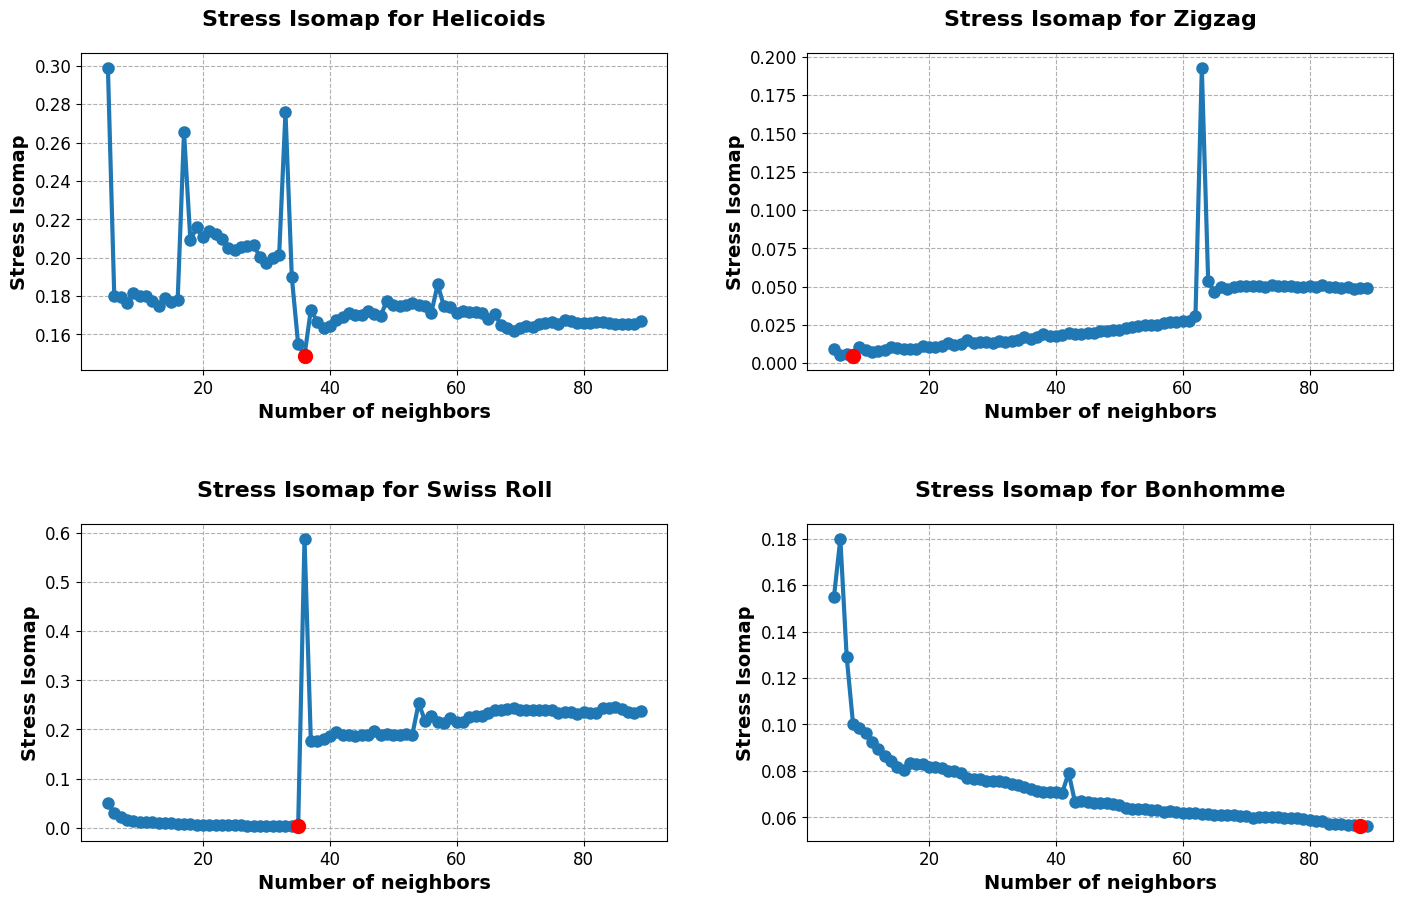

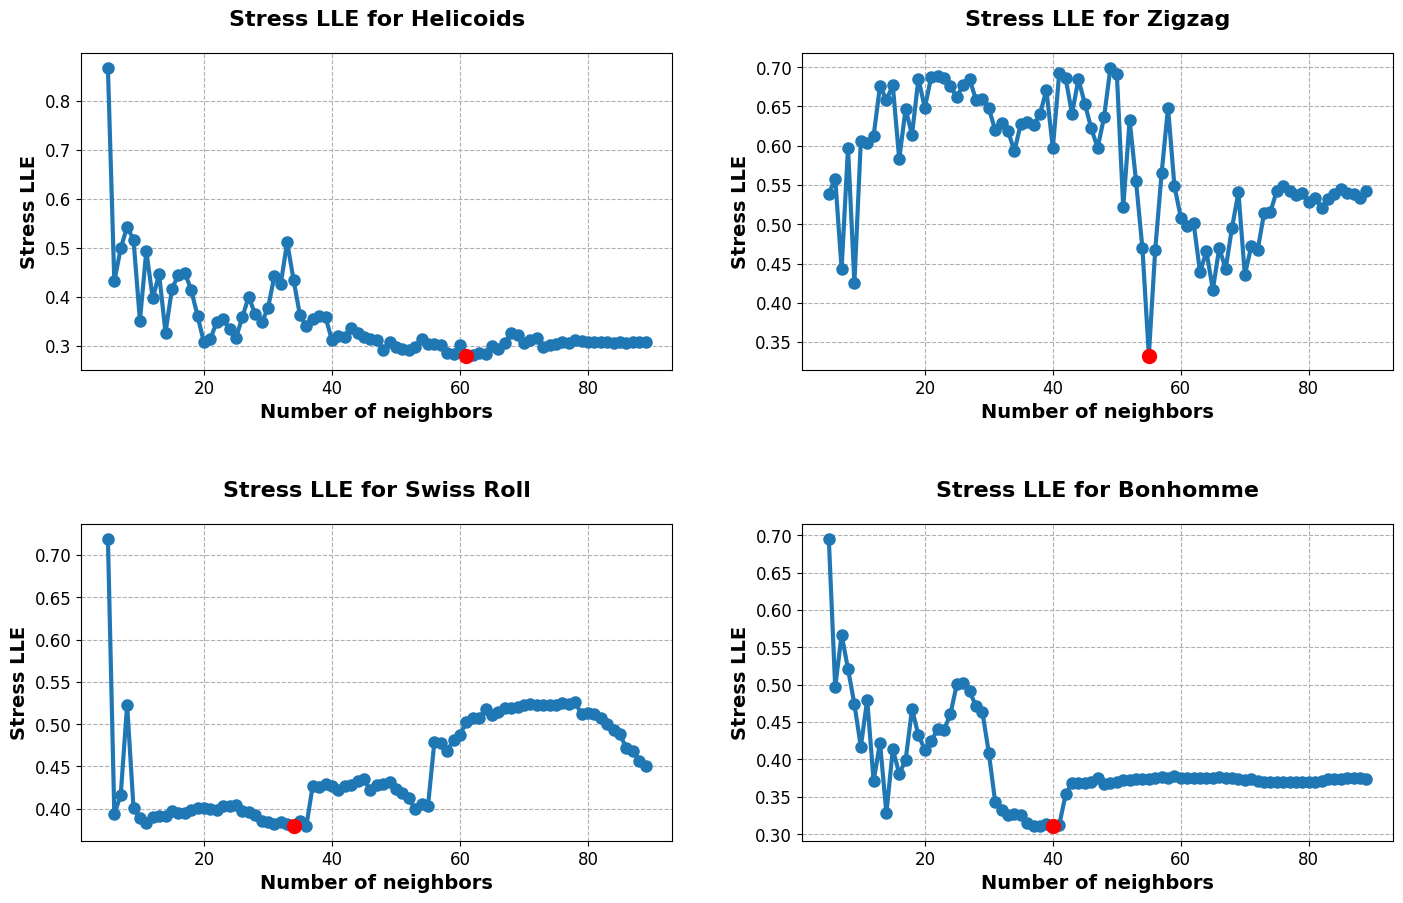

In [163]:
plot_error_curves(n_neighbors_list, errors_isomap, title_prefix="Stress Isomap")
plot_error_curves(n_neighbors_list, errors_lle,     title_prefix="Stress LLE")

### Preservation neighbors accuracy curves

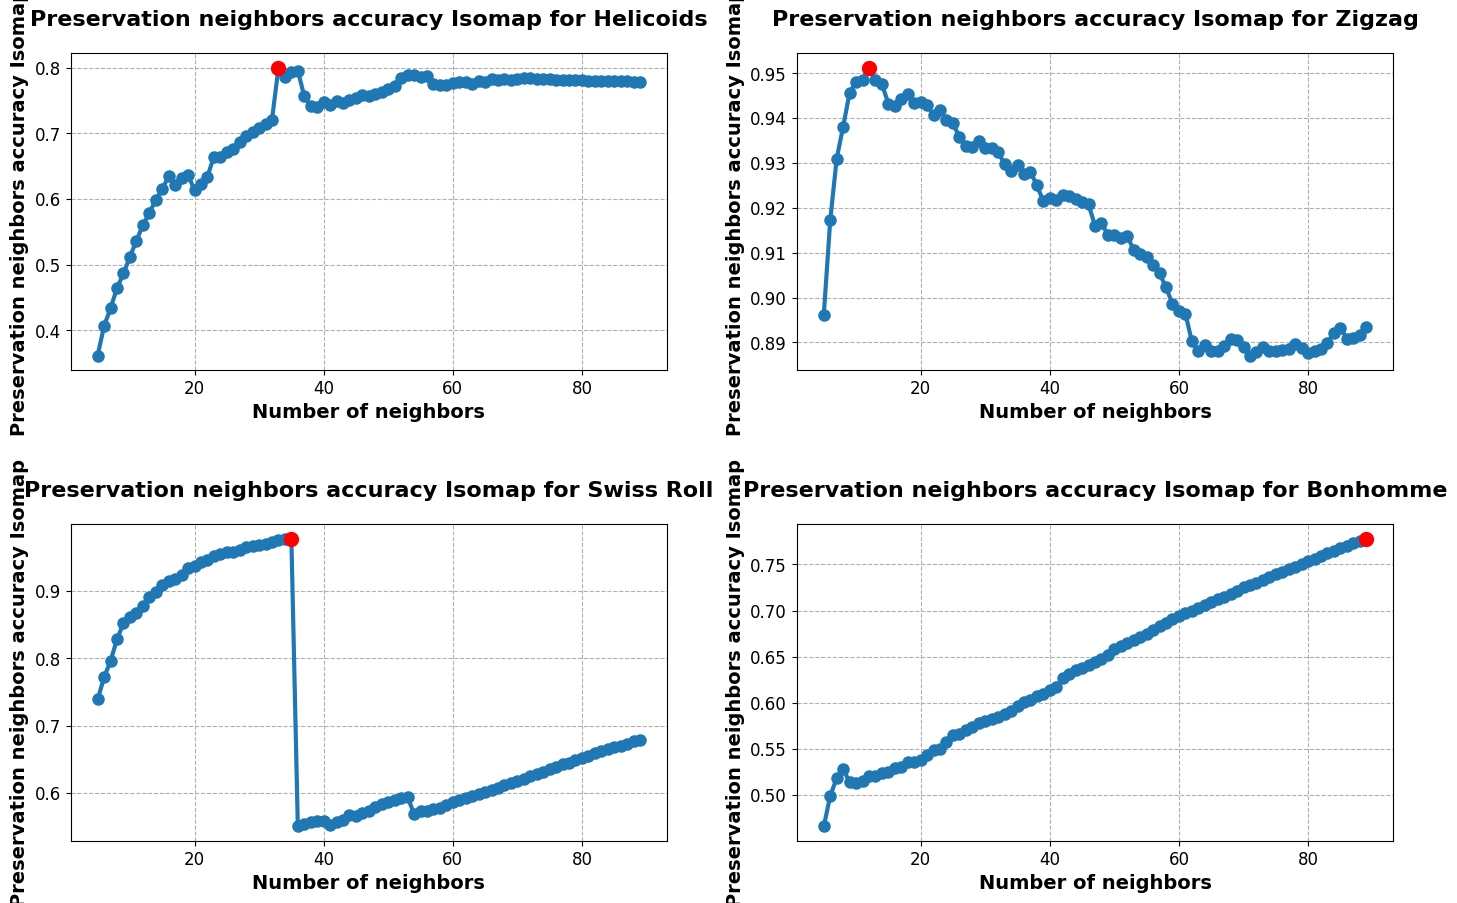

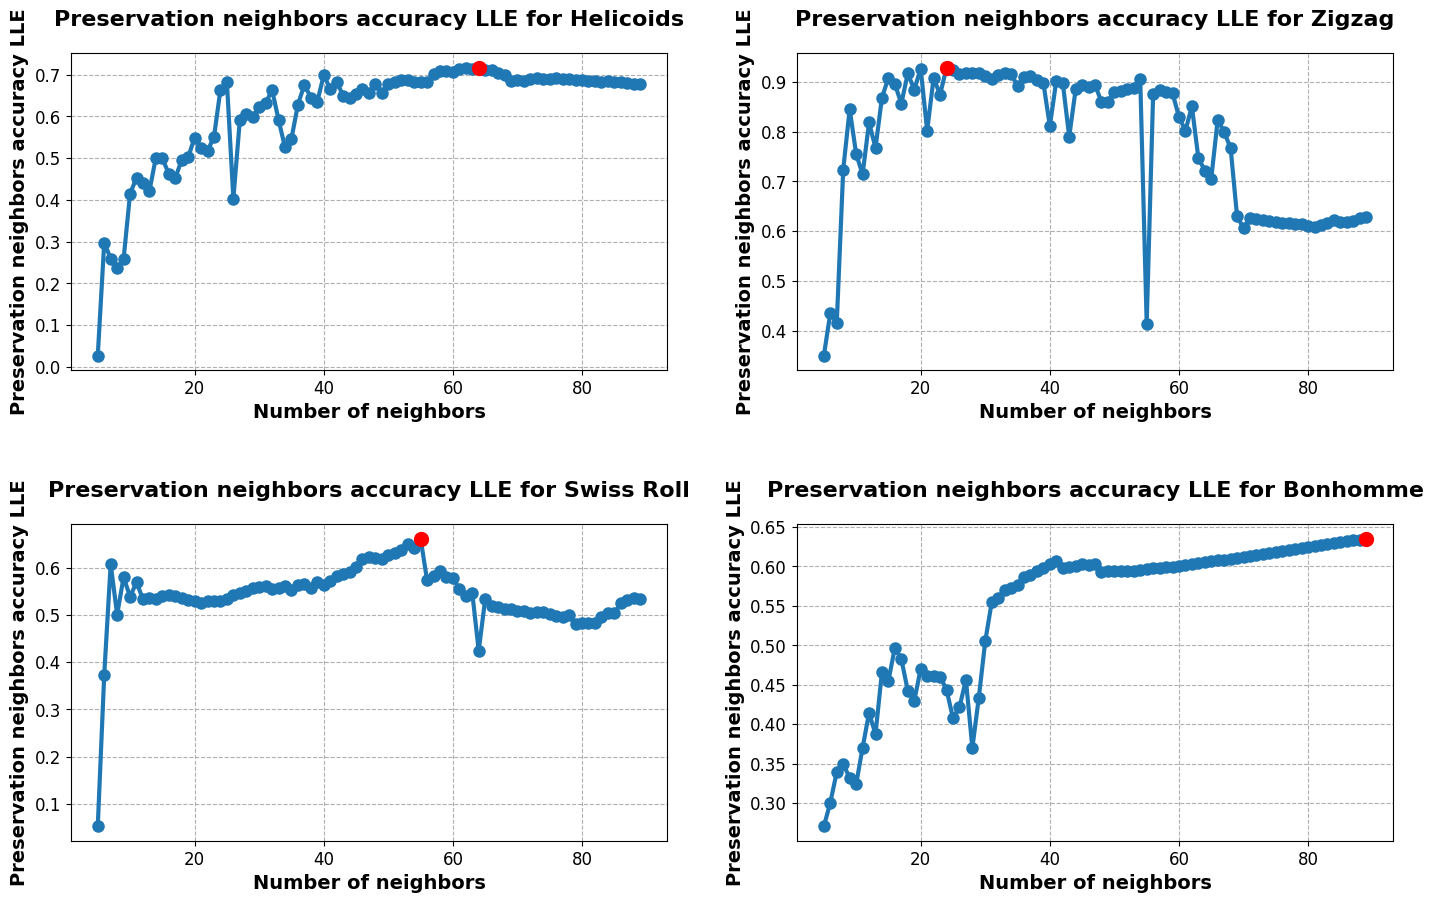

In [164]:
plot_error_curves(n_neighbors_list, neighbors_accuracy_isomap, title_prefix="Preservation neighbors accuracy Isomap", best=False)
plot_error_curves(n_neighbors_list, neighbors_accuracy_lle, title_prefix="Preservation neighbors accuracy LLE", best=False)

## Combinaison of the two metrics

In [165]:
import numpy as np
from sklearn.preprocessing import minmax_scale

# 1) Get the list of dataset names
dataset_names = list(datasets.keys())

# 2) Build "normalized" dictionaries manually (without scaling):
errors_isomap_normalized = {}
errors_lle_normalized    = {}
neighbors_accuracy_isomap_normalized = {}
neighbors_accuracy_lle_normalized    = {}

for ds_name in dataset_names:
    errors_isomap_normalized[ds_name] = np.array(errors_isomap[ds_name])
    errors_lle_normalized[ds_name]    = np.array(errors_lle[ds_name])
    neighbors_accuracy_isomap_normalized[ds_name] = np.array(neighbors_accuracy_isomap[ds_name])
    neighbors_accuracy_lle_normalized[ds_name]    = np.array(neighbors_accuracy_lle[ds_name])
    
# 3) Convert neighbor accuracy to "error-like" (1 - accuracy)
neighbors_accuracy_isomap_comparable = {}
neighbors_accuracy_lle_comparable = {}
for ds_name in dataset_names:
    neighbors_accuracy_isomap_comparable[ds_name] = 1.0 - neighbors_accuracy_isomap_normalized[ds_name]
    neighbors_accuracy_lle_comparable[ds_name]    = 1.0 - neighbors_accuracy_lle_normalized[ds_name]

# 4) Combine the two metrics (50-50 weighting) into dictionaries
isomap_metric = {}
lle_metric    = {}
for ds_name in dataset_names:
    err_iso = errors_isomap_normalized[ds_name]
    acc_iso = neighbors_accuracy_isomap_comparable[ds_name]
    isomap_metric[ds_name] = 0.5 * err_iso + 0.5 * acc_iso

    err_lle = errors_lle_normalized[ds_name]
    acc_lle = neighbors_accuracy_lle_comparable[ds_name]
    lle_metric[ds_name] = 0.5 * err_lle + 0.5 * acc_lle

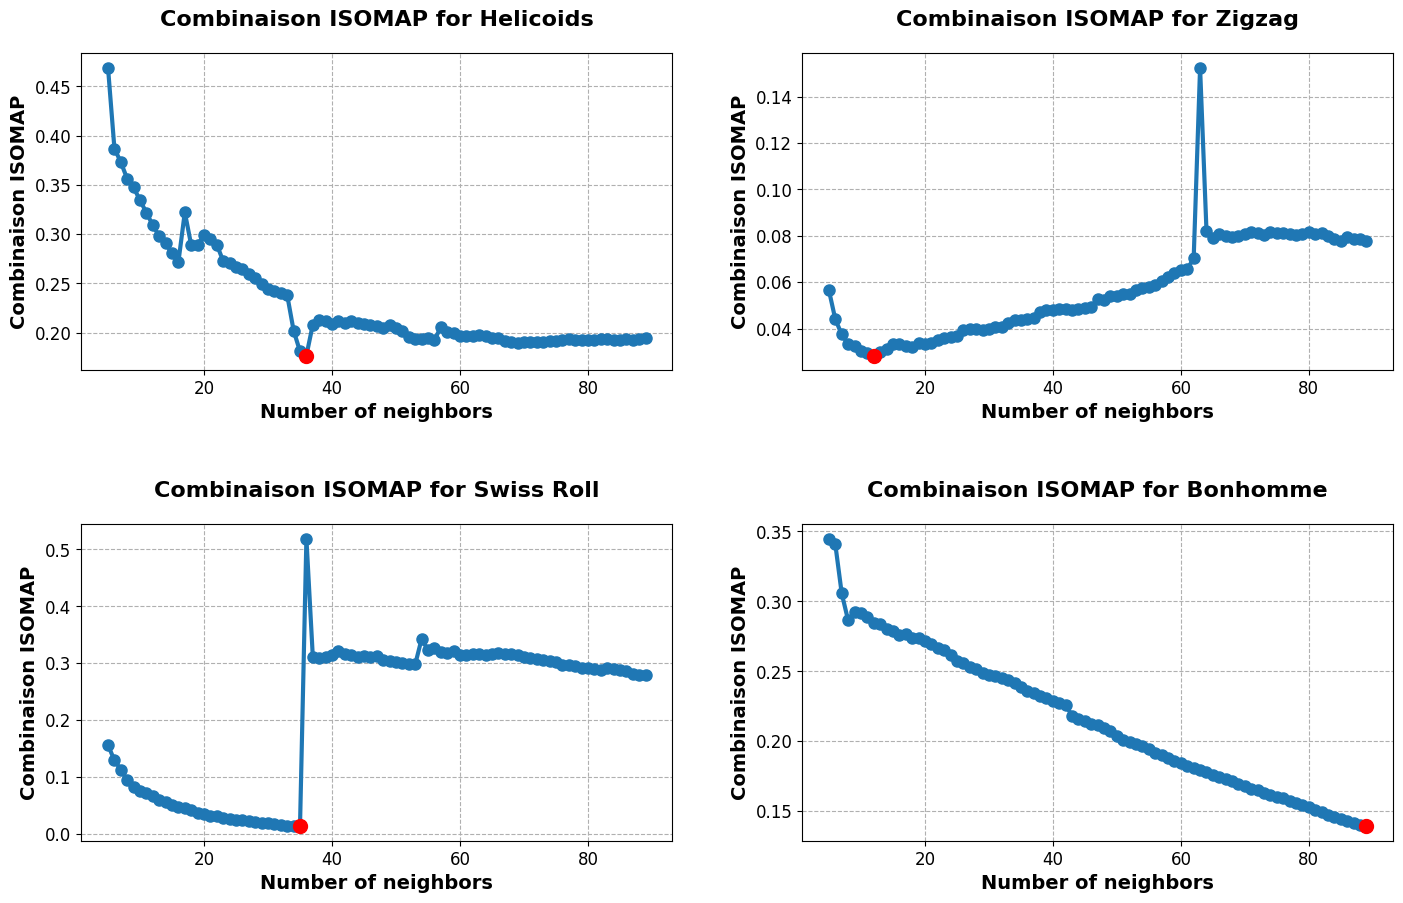

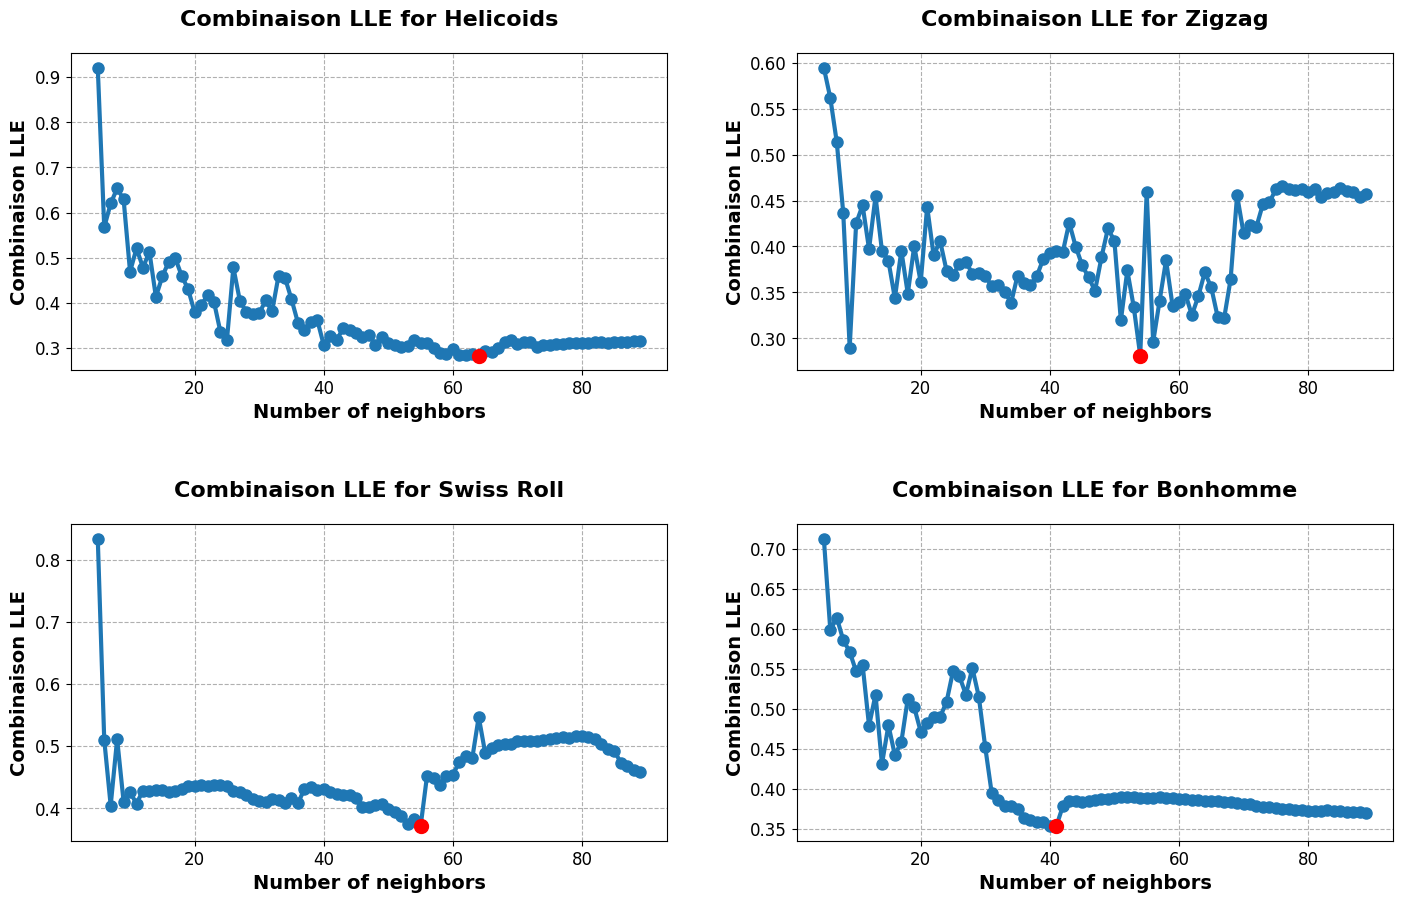

In [166]:


# plot the combinations of the two metrics
plot_error_curves(n_neighbors_list, isomap_metric, title_prefix="Combinaison ISOMAP")
plot_error_curves(n_neighbors_list, lle_metric, title_prefix="Combinaison LLE")


## Best parameters and vizualisation

In [170]:
best_isomap =  {'Helicoids':36, 'Zigzag':12, 'Swiss Roll':35, 'Bonhomme':89}
best_LLE = {'Helicoids':64, 'Zigzag':54, 'Swiss Roll':55, 'Bonhomme':41}

In [7]:
def plot_2d_best(datasets_dict, best_n_neighbors_dict, method='LLE'):
    """
    Plot 2D embeddings for 4 datasets using the best n_neighbors value for each.

    Parameters:
    -----------
    datasets_dict : dict
        Dictionary containing the datasets (X, y) pairs, keyed by dataset name.
    best_n_neighbors_dict : dict
        Dictionary with dataset names as keys and the best n_neighbors value (int) for each.
        Example: {'Helicoids': 36, 'Zigzag': 9, 'Swiss Roll': 21, 'Bonhomme': 81}
    method : str, optional
        'LLE' or 'ISOMAP' (default: 'LLE').

    The function creates a 2×2 grid of subplots, each showing the 2D embedding
    for one dataset.
    """
    import matplotlib.pyplot as plt
    from sklearn.manifold import LocallyLinearEmbedding, Isomap

    # Update matplotlib settings for a consistent plot style
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })

    # Create a 2x2 grid of subplots (since we have 4 datasets)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Ensure a consistent ordering of datasets
    dataset_names = list(best_n_neighbors_dict.keys())
    
    for i, dataset_name in enumerate(dataset_names):
        # Determine the subplot's row and column
        row = i // 2
        col = i % 2
        
        # Retrieve the data and the best n_neighbors value
        X, y = datasets_dict[dataset_name]
        n_neighbors = best_n_neighbors_dict[dataset_name]
        
        # Choose the manifold learning method
        try:
            if method.upper() == 'LLE':
                model = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2)
            elif method.upper() == 'ISOMAP':
                model = Isomap(n_neighbors=n_neighbors, n_components=2)
            else:
                raise ValueError("Method must be either 'LLE' or 'ISOMAP'")
            
            # Compute the embedding
            X_embedded = model.fit_transform(X)
            
            # Scatter plot of the embedding
            axes[row, col].scatter(
                X_embedded[:, 0], X_embedded[:, 1],
                c=y, cmap='viridis'
            )
            
            # Set title and remove tick labels for a cleaner look
            axes[row, col].set_title(f"{dataset_name}: n_neighbors = {n_neighbors}", fontweight='bold')
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_xlabel('Dimension 1', fontweight='bold')
            axes[row, col].set_ylabel('Dimension 2', fontweight='bold')
        
        except Exception as e:
            # In case of an error, display it in the corresponding subplot
            axes[row, col].text(
                0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', wrap=True
            )
            axes[row, col].set_title(dataset_name, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.show()


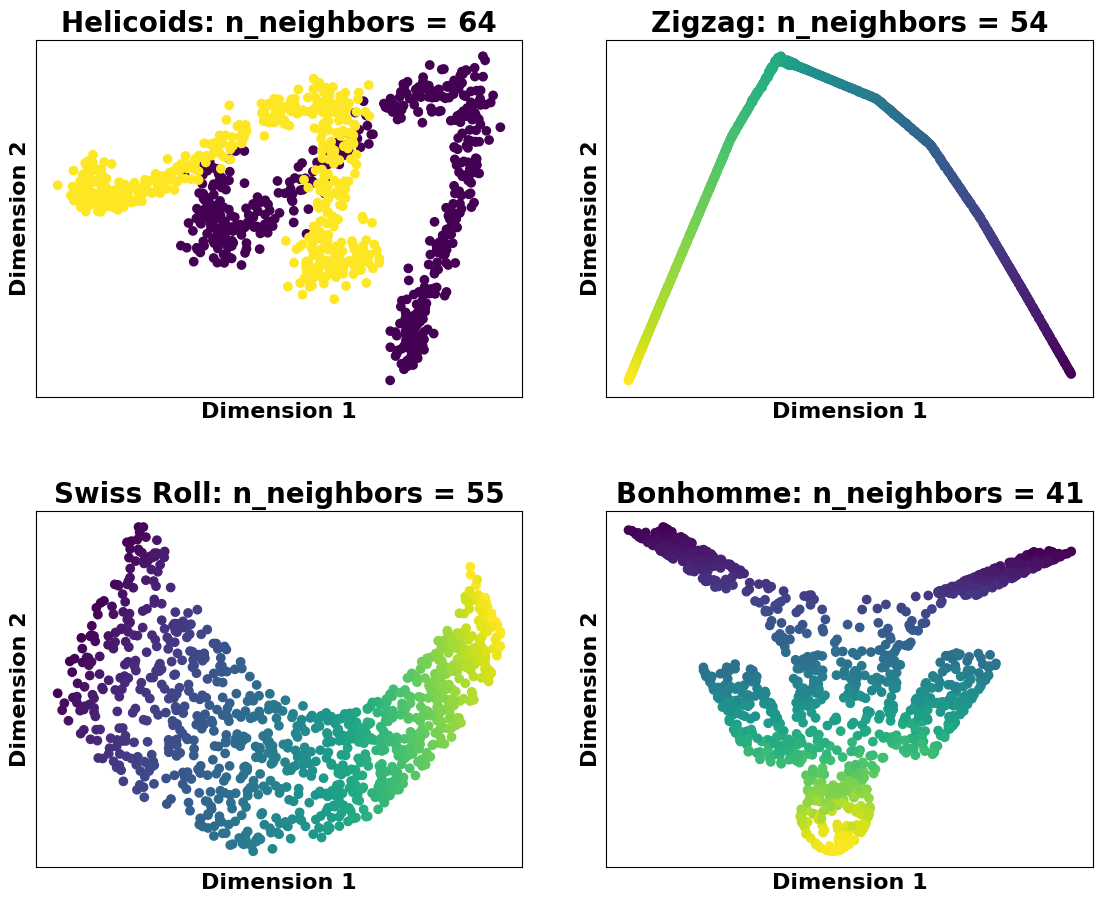

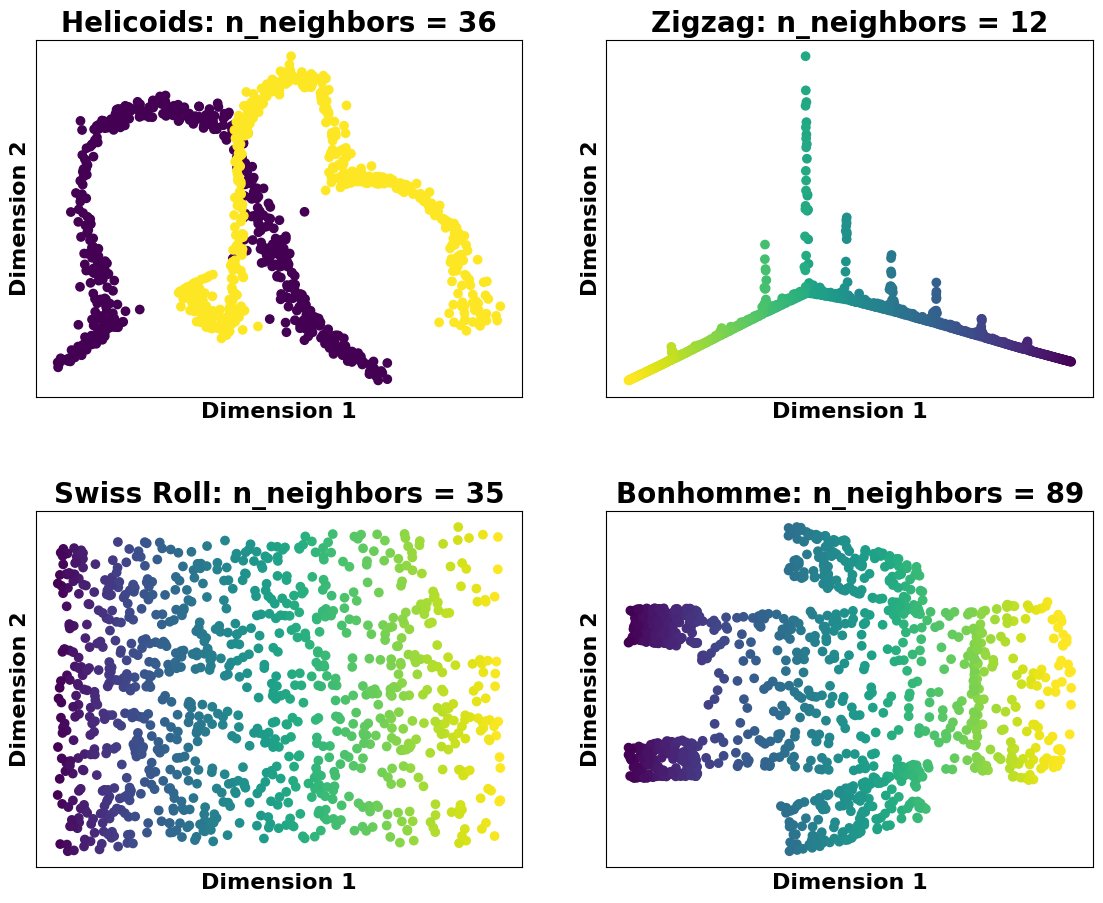

In [172]:
# Plot using LLE
plot_2d_best(datasets, best_LLE, method='LLE')

# Or plot using ISOMAP
plot_2d_best(datasets, best_isomap, method='ISOMAP')

# Real dataset

## Load dataset


In [9]:
from data_utils import load_real_dataset, DatasetManager
import config

dataset_name = 'data_real_data.pkl'
save_path = config.DATA_DIR

manager = DatasetManager(dataset_name, save_path, load_real_dataset)
dataset = manager.load_dataset()

Loading data_real_data.pkl from local storage.


## Selection of n_neighbors

In [10]:
n_neighbors_list = [i for i in range(5, 90)]
low_dimension = 2

# ISOMAP
(errors_isomap, neighbors_accuracy_isomap) = compute_geodesic_errors_neighbors_accuracy(
    n_neighbors_list,
    low_dimension,
    dataset,
    method='ISOMAP'
)
print('Method is ISOMAP')
for idx, (dataset_name, dataset_errors) in enumerate(zip(datasets.keys(), errors_isomap)):
    print(f"Geodesic stress errors for {dataset_name}: {dataset_errors}")

for idx, (dataset_name, dataset_scores) in enumerate(zip(datasets.keys(), neighbors_accuracy_isomap)):
    print(f"Neighbor preservation scores for {dataset_name}: {dataset_scores}")


# LLE
(errors_lle, neighbors_accuracy_lle) = compute_geodesic_errors_neighbors_accuracy(
    n_neighbors_list,
    low_dimension,
    dataset,
    method='LLE'
)

print('Method is LLE')
for idx, (dataset_name, dataset_errors) in enumerate(zip(dataset.keys(), errors_lle)):
    print(f"Euclidean-stress for {dataset_name}: {dataset_errors}")

for idx, (dataset_name, dataset_scores) in enumerate(zip(dataset.keys(), neighbors_accuracy_lle)):
    print(f"Neighbor-preservation for {dataset_name}: {dataset_scores}")

# Save the results
import pickle
with open(f'{config.DATA_DIR}/results_geodesic_stress_neighbors_accuracy_real_data.pkl', 'wb') as f:
    pickle.dump({'errors_isomap': errors_isomap, 'neighbors_accuracy_isomap': neighbors_accuracy_isomap,
                 'errors_lle': errors_lle, 'neighbors_accuracy_lle': neighbors_accuracy_lle}, f)


Processing dataset Real Data with n_neighbors=5
Processing dataset Real Data with n_neighbors=6
Processing dataset Real Data with n_neighbors=7
Processing dataset Real Data with n_neighbors=8
Processing dataset Real Data with n_neighbors=9
Processing dataset Real Data with n_neighbors=10
Processing dataset Real Data with n_neighbors=11
Processing dataset Real Data with n_neighbors=12
Processing dataset Real Data with n_neighbors=13
Processing dataset Real Data with n_neighbors=14
Processing dataset Real Data with n_neighbors=15
Processing dataset Real Data with n_neighbors=16
Processing dataset Real Data with n_neighbors=17
Processing dataset Real Data with n_neighbors=18
Processing dataset Real Data with n_neighbors=19
Processing dataset Real Data with n_neighbors=20
Processing dataset Real Data with n_neighbors=21
Processing dataset Real Data with n_neighbors=22
Processing dataset Real Data with n_neighbors=23
Processing dataset Real Data with n_neighbors=24
Processing dataset Real D

In [16]:
# load the results
with open(f'{config.DATA_DIR}/results_geodesic_stress_neighbors_accuracy_real_data.pkl', 'rb') as f:
    results = pickle.load(f)
    errors_isomap = results['errors_isomap']
    neighbors_accuracy_isomap = results['neighbors_accuracy_isomap']
    errors_lle = results['errors_lle']
    neighbors_accuracy_lle = results['neighbors_accuracy_lle']


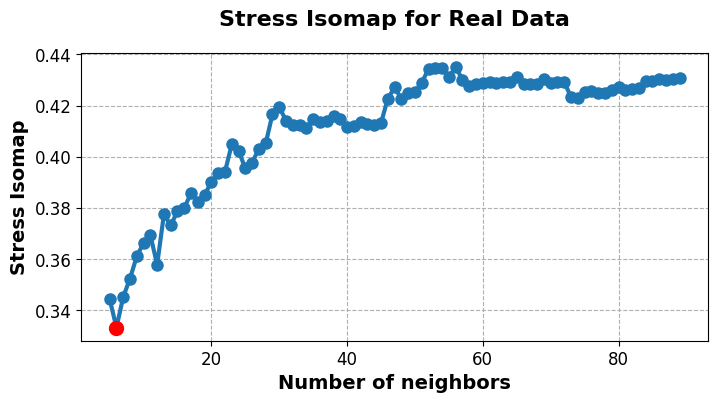

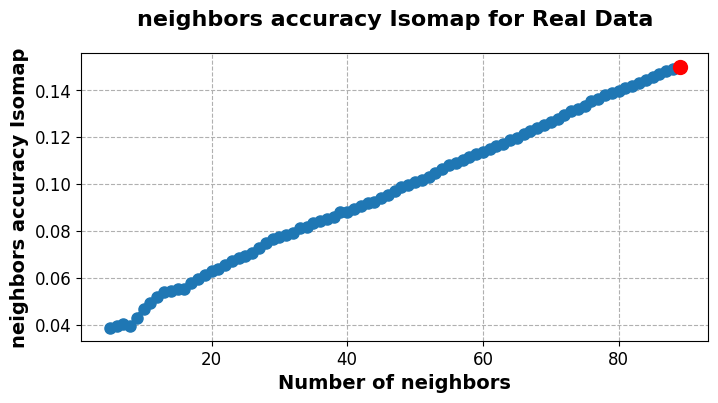

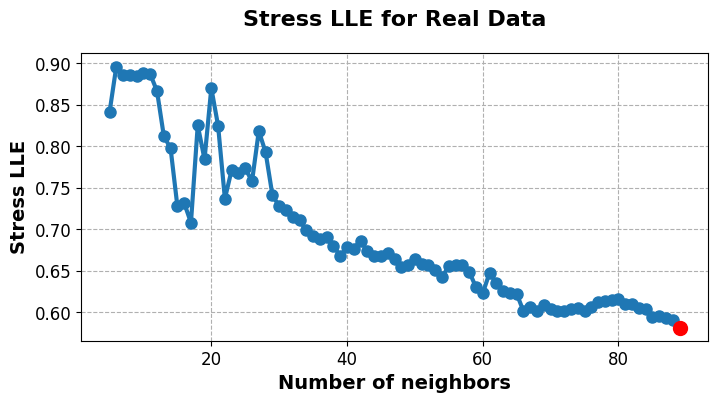

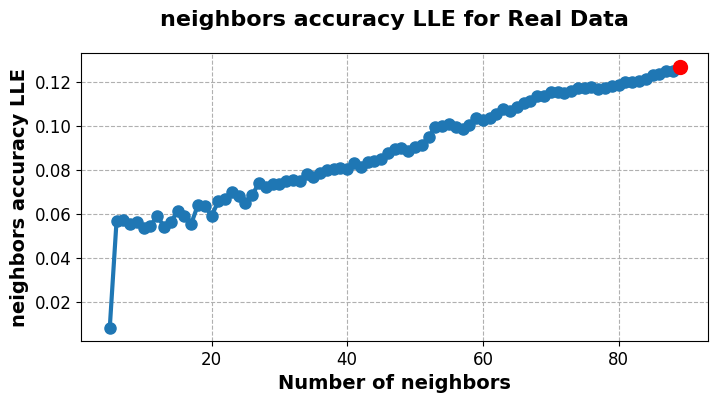

In [20]:
# plot the two metrics
plot_error_curves(n_neighbors_list, errors_isomap, title_prefix="Stress Isomap", best=True)
plot_error_curves(n_neighbors_list, neighbors_accuracy_isomap, title_prefix="neighbors accuracy Isomap", best=False)

# plot the two metrics
plot_error_curves(n_neighbors_list, errors_lle, title_prefix="Stress LLE", best=True)
plot_error_curves(n_neighbors_list, neighbors_accuracy_lle, title_prefix="neighbors accuracy LLE", best=False)


In [26]:
# Combinaison of the two metrics
lle_metric = {}
isomap_metric = {}

for ds_name in dataset.keys():
    err_iso = errors_isomap[ds_name]
    acc_iso = neighbors_accuracy_isomap[ds_name]
    isomap_metric[ds_name] = 0.5 * np.array(err_iso) + 0.5 * (1 - np.array(acc_iso))

    err_lle = errors_lle[ds_name]
    acc_lle = neighbors_accuracy_lle[ds_name]
    lle_metric[ds_name] = 0.5 * np.array(err_lle) + 0.5 * (1 - np.array(acc_lle))

    # the minimum value of the combinaison of the two metrics
    min_isomap_metric = min(isomap_metric[ds_name])
    min_lle_metric = min(lle_metric[ds_name])
    best_n_neighbors_isomap = np.argmin(isomap_metric[ds_name])
    best_n_neighbors_lle = np.argmin(lle_metric[ds_name])

    # the best n_neighbors value for each dataset
    print(f"The minimum value of the combinaison of the two metrics for ISOMAP is {min_isomap_metric} for n_neighbors = {best_n_neighbors_isomap + n_neighbors_list[0]}")
    print(f"The minimum value of the combinaison of the two metrics for LLE is {min_lle_metric} for n_neighbors = {best_n_neighbors_lle + n_neighbors_list[0]}")


The minimum value of the combinaison of the two metrics for ISOMAP is 0.6403939497187574 for n_neighbors = 89
The minimum value of the combinaison of the two metrics for LLE is 0.7271888813994043 for n_neighbors = 89


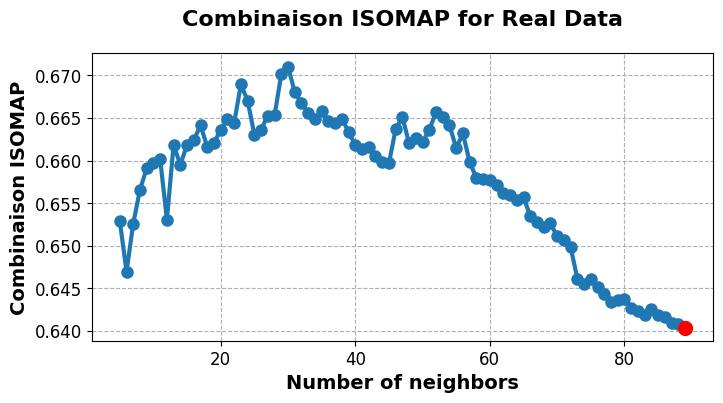

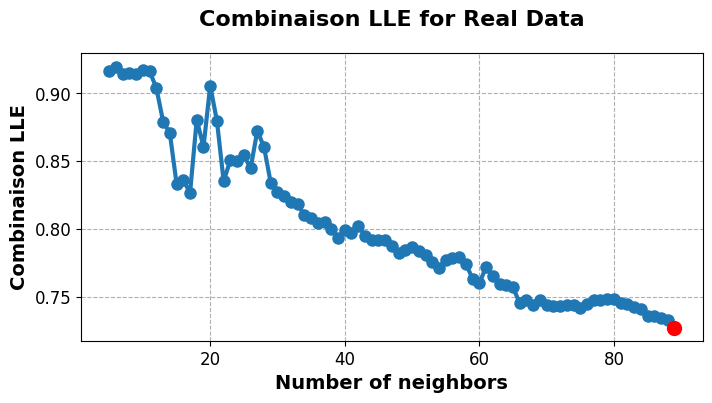

In [27]:
# plot lle metric and isomap metric results
plot_error_curves(n_neighbors_list, isomap_metric, title_prefix="Combinaison ISOMAP")
plot_error_curves(n_neighbors_list, lle_metric, title_prefix="Combinaison LLE")



